# 以LSTM演算法預測股價

## 載入相關套件 

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchtext
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

c:\Users\uscc_carl\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 判斷GPU是否存在

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 載入資料

In [3]:
#df = pd.read_csv('./nlp_data/AMZN_2006-01-01_to_2018-01-01.csv')
df = pd.read_csv('./nlp_data/btc_usdt_data.csv')
df.head()

,Date,open,high,low,Close,vol
0,2022-07-15 00:00:00+00:00,20591.3,20594.8,20579.7,20594.8,4.869115
1,2022-07-15 00:01:00+00:00,20594.5,20603.1,20590.5,20593.1,18.127575
2,2022-07-15 00:02:00+00:00,20595.4,20602.3,20579.5,20579.5,1.192547
3,2022-07-15 00:03:00+00:00,20575.3,20596.1,20550.7,20585.7,7.451167
4,2022-07-15 00:04:00+00:00,20585.8,20594.9,20581.5,20587.7,1.090570


In [4]:
df.tail()

,Date,open,high,low,Close,vol
98463,2022-09-21 09:03:00+00:00,18866.3,18866.9,18861.4,18861.4,0.893010
98464,2022-09-21 09:04:00+00:00,18861.5,18862.4,18861.5,18862.4,0.012011
98465,2022-09-21 09:05:00+00:00,18862.3,18865.0,18861.4,18865.0,0.932398
98466,2022-09-21 09:06:00+00:00,18865.4,18868.5,18865.4,18868.0,5.747388
98467,2022-09-21 09:07:00+00:00,18868.0,18868.0,18868.0,18868.0,0.000000


## 繪圖

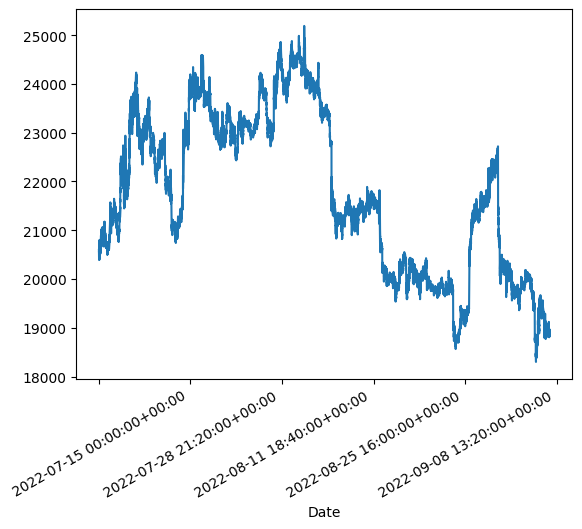

In [5]:
df2 = df.set_index('Date')
df2.Close.plot(legend=None)
plt.xticks(rotation=30);


In [6]:
len(df2)

98468

## 實驗一 : 直接透過給定的前幾天預測下一天

In [7]:
from sklearn.preprocessing import MinMaxScaler
look_back = 30 # 以前N期資料為 X，當期資料為 Y

# 函數：以前N期資料為 X，當前期資料為 Y
def create_dataset(data1, look_back):
    print(data1.shape)
    x, y = [], []
    for i in range(len(data1)-look_back-1):
        _x = data1[i:(i+look_back)]
        _y = data1[i+look_back]
        x.append(_x)
        y.append(_y)
    return torch.Tensor(np.array(x)), torch.Tensor(np.array(y))

dataset = df2[['Close']].values.astype('float32')
#dataset = df2.values.astype('float32')
# X 常態化
scaler = MinMaxScaler()
dataset = scaler.fit_transform(dataset)

# 資料分割
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train_data, test_data = dataset[0:train_size,:], dataset[train_size-look_back:len(dataset),:]

trainX, trainY = create_dataset(train_data, look_back)
testX, testY = create_dataset(test_data, look_back)
dataset.shape, trainY.shape

(65973, 1)
(32525, 1)


((98468, 1), torch.Size([65942, 1]))

In [8]:
dataset[-1]

array([0.08246589], dtype=float32)

In [9]:
trainX.shape, trainY.shape, testX.shape, testY.shape

(torch.Size([65942, 30, 1]),
 torch.Size([65942, 1]),
 torch.Size([32494, 30, 1]),
 torch.Size([32494, 1]))

In [10]:
torch.cat((trainX.reshape(trainX.shape[0], trainX.shape[1]), trainY), axis=1)

tensor([[0.3331, 0.3329, 0.3309,  ..., 0.3136, 0.3128, 0.3147],
        [0.3329, 0.3309, 0.3318,  ..., 0.3128, 0.3147, 0.3169],
        [0.3309, 0.3318, 0.3321,  ..., 0.3147, 0.3169, 0.3140],
        ...,
        [0.2722, 0.2725, 0.2728,  ..., 0.2604, 0.2618, 0.2614],
        [0.2725, 0.2728, 0.2750,  ..., 0.2618, 0.2614, 0.2620],
        [0.2728, 0.2750, 0.2737,  ..., 0.2614, 0.2620, 0.2616]])

## 建立模型

In [11]:
hidden_size = 10
num_layers = 1
feature_number = testX.shape[2]
class TimeSeriesModel(nn.Module):
    def __init__(self, look_back, hidden_size=4, num_layers=1):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.LSTM(feature_number, self.hidden_size, num_layers=self.num_layers
                           , batch_first=True)
        self.fc = nn.Linear(self.hidden_size, 1)
        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()

    def forward(self, x):
        #print(x.shape)
        # rnn_out, h_out = self.rnn(x)
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size,device=x.device)        
        c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size,device=x.device)
        out, (h_out, _) = self.rnn(x, (h_0, c_0))
        #print(h_out.shape)
        
        # 取最後一層的 h，並轉成二維
#         h_out = h_out[-1].view(-1, self.hidden_size)  
#         return self.fc(h_out)
        # 取最後一個輸出，並轉成二維
        flatten_output = out[:, -1].view(-1, self.hidden_size)  
        return self.fc(flatten_output)

model = TimeSeriesModel(look_back, hidden_size=hidden_size, num_layers=num_layers).to(device)

In [12]:
model

TimeSeriesModel(
  (rnn): LSTM(1, 10, batch_first=True)
  (fc): Linear(in_features=10, out_features=1, bias=True)
)

## 模型訓練

In [13]:
num_epochs = 2000
learning_rate = 0.01

def train(trainX, trainY):
    criterion = torch.nn.MSELoss()  # MSE
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    model.train()
    for epoch in range(num_epochs):
        trainX ,trainY = trainX.to(device), trainY.to(device) 
        optimizer.zero_grad()
        outputs = model(trainX)
        if epoch <= 0: print(outputs.shape)
        loss = criterion(outputs, trainY)    
        loss.backward()
        optimizer.step()
        if epoch % 100 == 0:
            print(f"Epoch: {epoch}, loss: {loss.item():.5f}")

train(trainX, trainY)

torch.Size([65942, 1])
Epoch: 0, loss: 0.51321
Epoch: 100, loss: 0.00155
Epoch: 200, loss: 0.00009
Epoch: 300, loss: 0.00004
Epoch: 400, loss: 0.00002
Epoch: 500, loss: 0.00002
Epoch: 600, loss: 0.00002
Epoch: 700, loss: 0.00002
Epoch: 800, loss: 0.00002
Epoch: 900, loss: 0.00002
Epoch: 1000, loss: 0.00002
Epoch: 1100, loss: 0.00001
Epoch: 1200, loss: 0.00001
Epoch: 1300, loss: 0.00001
Epoch: 1400, loss: 0.00001
Epoch: 1500, loss: 0.00001
Epoch: 1600, loss: 0.00001
Epoch: 1700, loss: 0.00001
Epoch: 1800, loss: 0.00001
Epoch: 1900, loss: 0.00001


## 模型評估

In [14]:
model.eval()
trainPredict = model(trainX.to(device)).cpu().detach().numpy()
testPredict = model(testX.to(device)).cpu().detach().numpy()
trainPredict.shape

(65942, 1)

In [15]:
trainY.shape, trainPredict.shape

(torch.Size([65942, 1]), (65942, 1))

In [16]:
from sklearn.metrics import mean_squared_error
import math 

# 還原常態化的訓練及測試資料
print(trainPredict.shape)
trainPredict = scaler.inverse_transform(trainPredict)
print(trainY.shape)
trainY_actual = scaler.inverse_transform(trainY)

testPredict = scaler.inverse_transform(testPredict)
testY_actual = scaler.inverse_transform(testY.reshape(-1, 1))

# 計算 RMSE
trainScore = math.sqrt(mean_squared_error(trainY_actual, trainPredict.reshape(-1)))
print(f'Train RMSE: {trainScore:.2f}')
testScore = math.sqrt(mean_squared_error(testY_actual, testPredict.reshape(-1)))
print(f'Test RMSE:  {testScore:.2f}')

(65942, 1)
torch.Size([65942, 1])
Train RMSE: 25.81
Test RMSE:  22.47


## 繪製實際資料和預測資料的圖表

In [17]:
dataset.shape

(98468, 1)

(98468, 1)
(98468, 1)


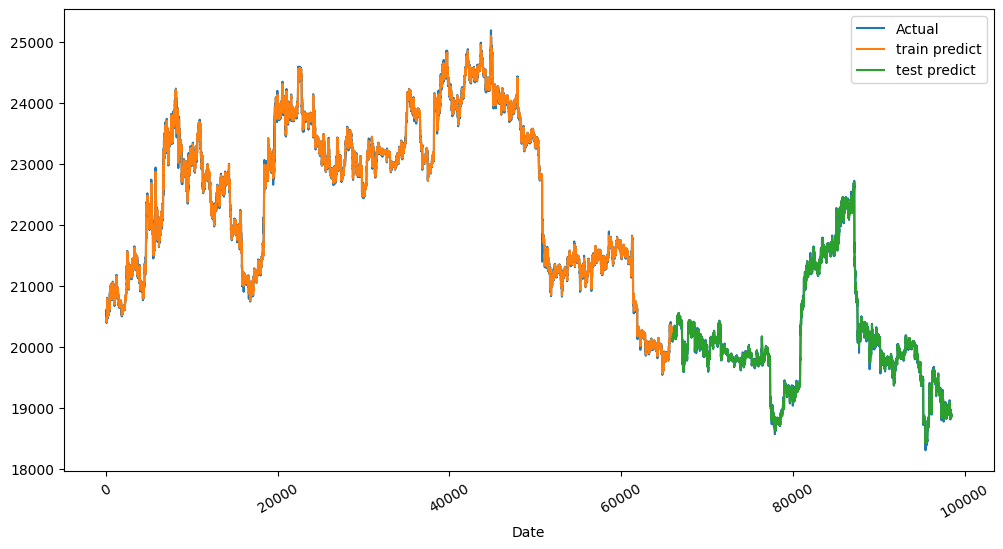

In [18]:
# 訓練資料的 X/Y
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
#trainPredictPlot[:look_back] = 0
print(trainPredictPlot.shape)
# 測試資料 X/Y
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[-testPredict.shape[0]-1:-1, :] = testPredict

print(testPredictPlot.shape)
# 繪圖
plt.figure(figsize=(12,6))
plt.plot(scaler.inverse_transform(dataset), label='Actual')
plt.plot(trainPredictPlot, label='train predict')
plt.plot(testPredictPlot, label='test predict')
plt.xticks(rotation=30)
plt.xlabel("Date")
plt.legend()
plt.show()


98468


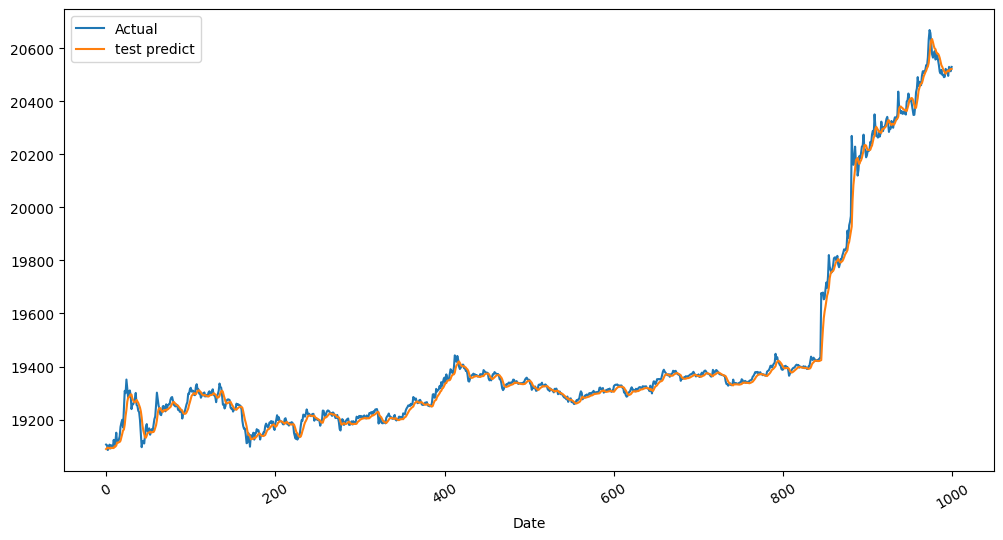

In [19]:
# 繪圖
plt.figure(figsize=(12,6))
print(trainPredictPlot.shape[0])
plt.plot(scaler.inverse_transform(dataset[80000:81000]), label='Actual')
plt.plot(testPredictPlot[80000-trainPredictPlot.shape[0]:81000-trainPredictPlot.shape[0]], label='test predict')
plt.xticks(rotation=30);
plt.xlabel("Date")
plt.legend()
plt.show()

## 改變Loopback=3：X由前1期改為前3期 

In [20]:
# 以前期資料為 X，當前期資料為 Y
look_back = 3
trainX, trainY = create_dataset(train_data, look_back)
testX, testY = create_dataset(test_data, look_back)

model = TimeSeriesModel(look_back, hidden_size=4, num_layers=1).to(device)
train(trainX, trainY)

(65973, 1)
(32525, 1)
torch.Size([65969, 1])
Epoch: 0, loss: 0.82248
Epoch: 100, loss: 0.03054
Epoch: 200, loss: 0.02074
Epoch: 300, loss: 0.00184
Epoch: 400, loss: 0.00015
Epoch: 500, loss: 0.00010
Epoch: 600, loss: 0.00009
Epoch: 700, loss: 0.00008
Epoch: 800, loss: 0.00008
Epoch: 900, loss: 0.00007
Epoch: 1000, loss: 0.00007
Epoch: 1100, loss: 0.00007
Epoch: 1200, loss: 0.00006
Epoch: 1300, loss: 0.00006
Epoch: 1400, loss: 0.00006
Epoch: 1500, loss: 0.00005
Epoch: 1600, loss: 0.00005
Epoch: 1700, loss: 0.00005
Epoch: 1800, loss: 0.00005
Epoch: 1900, loss: 0.00005


In [21]:
from sklearn.metrics import mean_squared_error
import math 

model.eval()
trainPredict = model(trainX).detach().numpy()
testPredict = model(testX).detach().numpy()

# 還原常態化的訓練及測試資料
trainPredict = scaler.inverse_transform(trainPredict)
trainY_actual = scaler.inverse_transform(trainY.reshape(-1, 1))
testPredict = scaler.inverse_transform(testPredict)
testY_actual = scaler.inverse_transform(testY.reshape(-1, 1))
print(trainY_actual.shape, trainPredict.shape)

# 計算 RMSE
trainScore = math.sqrt(mean_squared_error(trainY_actual, trainPredict.reshape(-1)))
print(f'Train RMSE: {trainScore:.2f}')
testScore = math.sqrt(mean_squared_error(testY_actual, testPredict.reshape(-1)))
print(f'Test RMSE:  {testScore:.2f}')

RuntimeError: Input and parameter tensors are not at the same device, found input tensor at cpu and parameter tensor at cuda:0

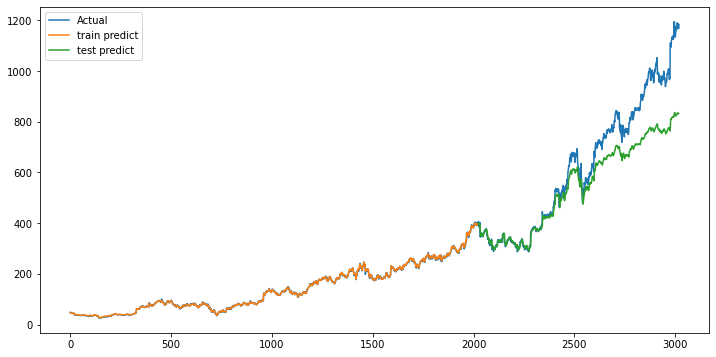

In [ ]:
# 訓練資料的 X/Y
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[1:trainPredict.shape[0]+1:, :] = trainPredict

# 測試資料 X/Y
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[-testPredict.shape[0]-1:-1, :] = testPredict

# 繪圖
plt.figure(figsize=(12,6))
plt.plot(scaler.inverse_transform(dataset), label='Actual')
plt.plot(trainPredictPlot, label='train predict')
plt.plot(testPredictPlot, label='test predict')
plt.legend()
plt.show()

## Stacked LSTM

In [ ]:
# 以前期資料為 X，當前期資料為 Y
look_back = 3
trainX, trainY = create_dataset(train_data, look_back)
testX, testY = create_dataset(test_data, look_back)

model = TimeSeriesModel(look_back, hidden_size=4, num_layers=3).to(device)
train(trainX, trainY)

torch.Size([2018, 1])
Epoch: 0, loss: 0.03376
Epoch: 100, loss: 0.00369
Epoch: 200, loss: 0.00008
Epoch: 300, loss: 0.00004
Epoch: 400, loss: 0.00003
Epoch: 500, loss: 0.00002
Epoch: 600, loss: 0.00002
Epoch: 700, loss: 0.00002
Epoch: 800, loss: 0.00004
Epoch: 900, loss: 0.00002
Epoch: 1000, loss: 0.00002
Epoch: 1100, loss: 0.00002
Epoch: 1200, loss: 0.00002
Epoch: 1300, loss: 0.00002
Epoch: 1400, loss: 0.00002
Epoch: 1500, loss: 0.00002
Epoch: 1600, loss: 0.00002
Epoch: 1700, loss: 0.00001
Epoch: 1800, loss: 0.00001
Epoch: 1900, loss: 0.00001


In [ ]:
from sklearn.metrics import mean_squared_error
import math 

model.eval()
trainPredict = model(trainX).detach().numpy()
testPredict = model(testX).detach().numpy()

# 還原常態化的訓練及測試資料
trainPredict = scaler.inverse_transform(trainPredict)
trainY_actual = scaler.inverse_transform(trainY.reshape(-1, 1))
testPredict = scaler.inverse_transform(testPredict)
testY_actual = scaler.inverse_transform(testY.reshape(-1, 1))
print(trainY_actual.shape, trainPredict.shape)

# 計算 RMSE
trainScore = math.sqrt(mean_squared_error(trainY_actual, trainPredict.reshape(-1)))
print(f'Train RMSE: {trainScore:.2f}')
testScore = math.sqrt(mean_squared_error(testY_actual, testPredict.reshape(-1)))
print(f'Test RMSE:  {testScore:.2f}')

(2018, 1) (2018, 1)
Train RMSE: 4.37
Test RMSE:  157.01


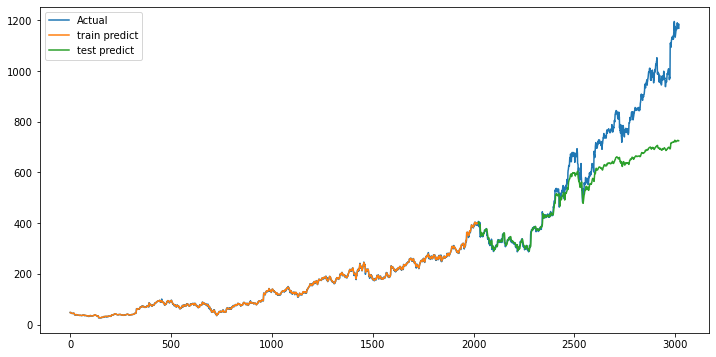

In [ ]:
# 訓練資料的 X/Y
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[1:trainPredict.shape[0]+1:, :] = trainPredict

# 測試資料 X/Y
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[-testPredict.shape[0]-1:-1, :] = testPredict

# 繪圖
plt.figure(figsize=(12,6))
plt.plot(scaler.inverse_transform(dataset), label='Actual')
plt.plot(trainPredictPlot, label='train predict')
plt.plot(testPredictPlot, label='test predict')
plt.legend()
plt.show()

## 預測多期

In [ ]:
# 函數：以前N期資料為 X，當前期資料為 Y
def create_dataset(data1, look_back, forward_days):
    x, y = [], []
    for i in range(len(data1) - look_back - forward_days + 1):
        _x = data1[i:(i+look_back)]
        _y = data1[i+look_back:(i+look_back+forward_days)]
        x.append(_x)
        y.append(_y)

    x, y = np.array(x), np.array(y)
    return torch.Tensor(x), torch.Tensor(y.reshape(y.shape[0], y.shape[1]))

## 建立資料集

In [ ]:
look_back = 10 # 以前10期資料為 X
forward_days = 10  # 預測天數
trainX, trainY = create_dataset(train_data, look_back, forward_days)
testX, testY = create_dataset(test_data, look_back, forward_days)

In [ ]:
train_data.shape, test_data.shape

((2022, 1), (997, 1))

In [ ]:
trainX.shape, trainY.shape

(torch.Size([2003, 10, 1]), torch.Size([2003, 10]))

## 建立模型

In [ ]:
class TimeSeriesModel(nn.Module):
    def __init__(self, look_back, forward_days, hidden_size=4, num_layers=1):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.LSTM(1, self.hidden_size, num_layers=self.num_layers
                           , batch_first=True)
        self.fc = nn.Linear(self.hidden_size, forward_days)
        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()

    def forward(self, x):
        #print(x.shape)
        # rnn_out, h_out = self.rnn(x)
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)        
        c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        out, (h_out, _) = self.rnn(x, (h_0, c_0))
        #print(h_out.shape)
        
        # 取最後一層的 h，並轉成二維
        # h_out = h_out[-1].view(-1, self.hidden_size)  
        # return self.fc(h_out)
        # 取最後一個輸出，並轉成二維
        flatten_output = out[:, -1].view(-1, self.hidden_size)  
        return self.fc(flatten_output)

model = TimeSeriesModel(look_back, forward_days, hidden_size=20,
                        num_layers=1).to(device)

## 模型訓練

In [ ]:
def train(trainX, trainY):
    criterion = torch.nn.MSELoss()  # MSE
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        optimizer.zero_grad()
        outputs = model(trainX)
        if epoch <= 0: print(outputs.shape, trainY.shape)
        loss = criterion(outputs, trainY)    
        loss.backward()
        optimizer.step()
        if epoch % 100 == 0:
            print(f"Epoch: {epoch}, loss: {loss.item():.5f}")

train(trainX, trainY)

torch.Size([2003, 10]) torch.Size([2003, 10])
Epoch: 0, loss: 0.06312
Epoch: 100, loss: 0.00007
Epoch: 200, loss: 0.00005
Epoch: 300, loss: 0.00005
Epoch: 400, loss: 0.00005
Epoch: 500, loss: 0.00005
Epoch: 600, loss: 0.00005
Epoch: 700, loss: 0.00005
Epoch: 800, loss: 0.00005
Epoch: 900, loss: 0.00005
Epoch: 1000, loss: 0.00004
Epoch: 1100, loss: 0.00004
Epoch: 1200, loss: 0.00004
Epoch: 1300, loss: 0.00004
Epoch: 1400, loss: 0.00005
Epoch: 1500, loss: 0.00004
Epoch: 1600, loss: 0.00004
Epoch: 1700, loss: 0.00004
Epoch: 1800, loss: 0.00004
Epoch: 1900, loss: 0.00004


In [ ]:
from sklearn.metrics import mean_squared_error
import math 

model.eval()
trainPredict = model(trainX).detach().numpy()
testPredict = model(testX).detach().numpy()

# 還原常態化的訓練及測試資料
trainPredict = scaler.inverse_transform(trainPredict)
trainY_actual = scaler.inverse_transform(trainY.reshape(-1, 1))
testPredict = scaler.inverse_transform(testPredict)
testY_actual = scaler.inverse_transform(testY.reshape(-1, 1))
print(trainY_actual.shape, trainPredict.shape)

# 計算 RMSE
trainScore = math.sqrt(mean_squared_error(trainY_actual, trainPredict.reshape(-1)))
print(f'Train RMSE: {trainScore:.2f}')
testScore = math.sqrt(mean_squared_error(testY_actual, testPredict.reshape(-1)))
print(f'Test RMSE:  {testScore:.2f}')

(20030, 1) (2003, 10)
Train RMSE: 7.68
Test RMSE:  30.99


## 繪圖

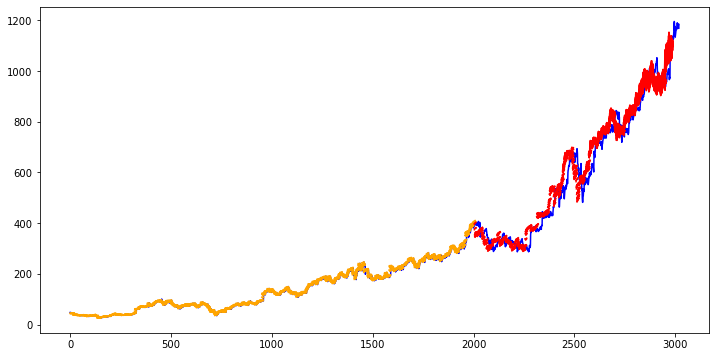

In [ ]:
plt.figure(figsize=(12,6))
# 真實資料
plt.plot(range(len(dataset)), scaler.inverse_transform(dataset), 'b', label='Actual')

# 訓練資料
for i in range(trainPredict.shape[0]):
    plt.plot(range(i, i+forward_days), trainPredict[i], 'orange')

# 測試資料    
for i in range(testPredict.shape[0]):
    plt.plot(range(i+trainPredict.shape[0], i+trainPredict.shape[0]+forward_days), 
             testPredict[i], 'r')
plt.show()

## 只繪製 20 條預測值

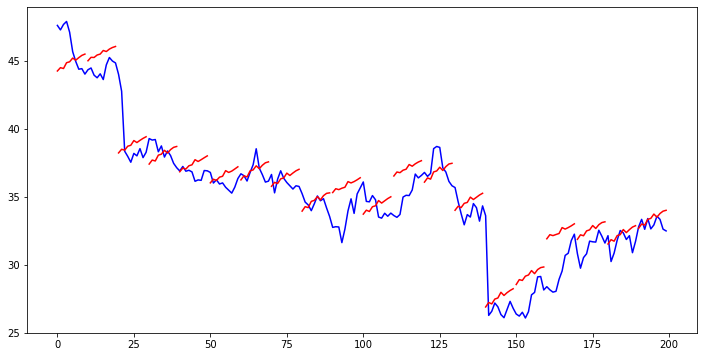

In [ ]:
n = 20
plt.figure(figsize=(12,6))
# 真實資料
plt.plot(range(forward_days*n), scaler.inverse_transform(dataset[:forward_days*n]), 'b', label='Actual')

# 訓練資料
for i in range(n):
    plt.plot(range(i*forward_days, (i+1)*forward_days), trainPredict[i*forward_days], 'r')

plt.show()